# Multiclass Classification Project

  Learning Goals : 

 - How to read different size images from a directory?
 - How to implement One-vs-one scheme for Multiclass classification?
 - How to use SVM for image classifcation?

## Dataset Preparation 

In [1]:
import numpy as np 
import os 
from pathlib import Path
# Both last two are imported to work with directories and folders

from keras.preprocessing import image ##to read image and process them ----we can use matplotlib or opencv r keras ....here we use keras

In [2]:
#pip install pillow

In [3]:
p = Path("../Project- IMAGE CLASSIFICATION/images")

dirs = p.glob("*") # glob function lets us explore the file that we have inside of the path given 
# star mean --" everything"

In [4]:

labels_dict= {'cats':0 ,'dogs':1 , 'horses':2 ,'humans':3}
labels = []
image_data =[]

for folder_dir in dirs : 
    #print(folder_name)
    
    label = str(folder_dir).split("\\")[-1]
    #print(label)
    
    for img_path in folder_dir.glob("*.jpg"):
        #print(img_path)
        
        img = image.load_img(img_path, target_size=(32,32)) #every image is of diff size ,therefore to get stnd sized images we give some target size 
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])

In [5]:
print(len(image_data)) 
print(len(labels))

808
808


In [6]:
image_data= np.array(image_data,dtype="float32")/255.0
labels = np.array(labels)

In [7]:
print(image_data.shape ,labels.shape)

(808, 32, 32, 3) (808,)


i.e we have 808 images each of 100 *100 size and each having 3 channels

# Randomly shuffle your data

In [8]:
import random 
combined = list(zip(image_data,labels))
random.shuffle(combined)

#unzip 
image_data[:],labels[:] = zip(*combined)

# Visualise this data!

In [9]:
def drawimg(img): 
    import matplotlib.pyplot as plt 
    
    plt.imshow(img)
    plt.show()
    return 

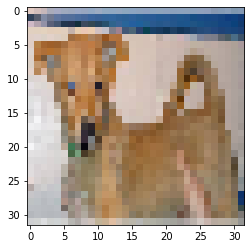

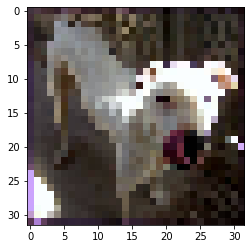

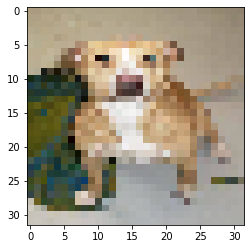

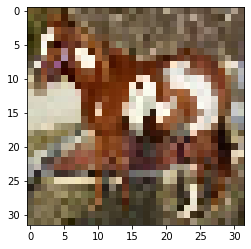

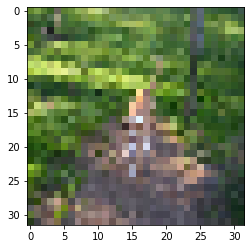

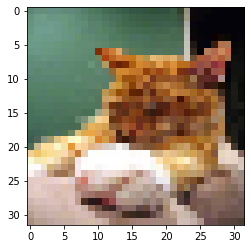

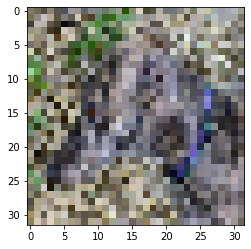

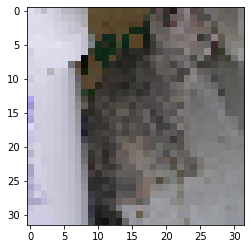

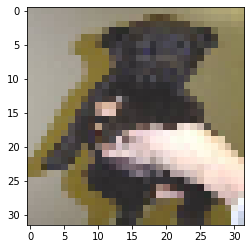

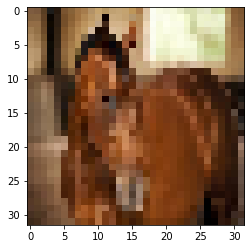

In [10]:
for i in range(10): 
    
    drawimg(image_data[i])

# SVM classifier

In [11]:
class SVM:
    """SVM Class, Author : Prateek Narang"""
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update rule that we discussed!
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

# We need to convert data for One-for-One classifcation!¶


In [12]:
M = image_data.shape[0] # to get the total number of samples 
image_data = image_data.reshape((M,-1)) # we have flattened all the images into a single row
print(image_data.shape)
print(labels.shape)

(808, 3072)
(808,)


In [13]:
CLASSES = len(np.unique(labels))
print(CLASSES)

4


In [14]:
def classwiseData(X,y) :
    data ={}
    
    for i in range(CLASSES): 
        data[i] = []
        
    for i in range(X.shape[0]):
        data[y[i]].append(X[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data
        
        
        

In [15]:
data = classwiseData(image_data,labels)

In [16]:
print(data[0].shape[0])
print(data[1].shape[0])
print(data[2].shape[0])
print(data[3].shape[0])


202
202
202
202


In [17]:
def getDataPairForSVM(d1,d2):
    """Combines Data of two classes into a single matrix"""
    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair,data_labels


# Training NC2 SVM's part

In [18]:
import matplotlib.pyplot as plt

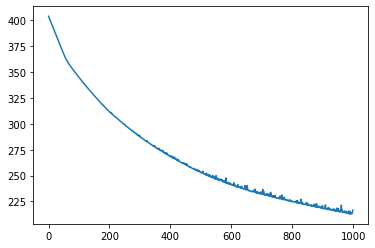

In [20]:
mySVM  = SVM()
xp, yp  = getDataPairForSVM(data[0],data[1])
w,b,loss  = mySVM.fit(xp,yp,learning_rate=0.00001,maxItr=1000)
#print(loss)
plt.plot(loss)

In [21]:
def trainSVMs(x,y):
    
    svm_classifiers = {}
    for i in range(CLASSES):
        svm_classifiers[i] = {}
        for j in range(i+1,CLASSES):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            #wts,b,loss = mySVM.fit(xpair,ypair)  # -> gives bad accuracy 
            #wts,b,loss = mySVM.fit(xpair,ypair , learning_rate=0.00001 , maxItr=500) # does minimise loss to an extent but still it is more
            wts,b,loss = mySVM.fit(xpair,ypair , learning_rate=0.00001, maxItr=1000)
            svm_classifiers[i][j] = (wts,b) #for every class of data we are taking some wts and baises and we are storing them in a dictionary
            
            plt.plot(loss)
            plt.show()
    
    return svm_classifiers
    
    

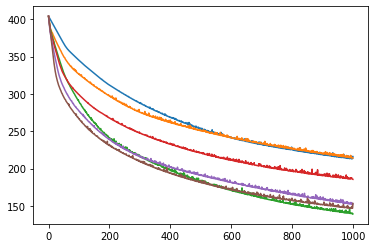

In [22]:
svm_classifiers =  trainSVMs(image_data,labels)


In [23]:
cat_dogs = svm_classifiers[0][1]
cats_humans = svm_classifiers[0][3]

In [24]:
print(cat_dogs[0]) #gives us the weights
print(cat_dogs[1]) #gives us the biases
print(cat_dogs[0].shape)
print(cat_dogs[1].shape)

[[-0.02655969 -0.0154268  -0.02698923 ...  0.00430802  0.00531978
  -0.00284776]]
-0.0373499999999999
(1, 3072)
()


In [34]:
#Parameters for Cats and dogs
cats_dogs = svm_classifiers[0][1]
cats_humans = svm_classifiers[0][3]
print(cats_dogs[0].shape)
print(cats_dogs[1])

(1, 3072)
-0.0373499999999999


In [26]:
print(cats_humans[0].shape) # this shows that we have 3072 features 

(1, 3072)


In [27]:
image_data.shape

(808, 3072)

In [28]:
labels.shape

(808,)

# Predictions

In [50]:
def binaryPredict(x,w,b) : 
    z  = np.dot(x,w.T) + b
    
    if z>=0: 
        return 1
    else: 
        return -1


In [65]:

    
def predict(x):
    
    count = np.zeros((CLASSES,))
    
    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b = svm_classifiers[i][j]
            #Take a majority prediction 
            z = binaryPredict(x,w,b)
            
            if(z==1):
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    #print(count)
    return final_prediction

In [66]:
print(predict(image_data[3]))
print(labels[3])

0
2


In [67]:
for i in range(10) : 
    print(labels[i])
    print(predict(image_data[i]))
    print("******")


1
2
******
1
0
******
1
0
******
2
0
******
1
1
******
0
0
******
1
1
******
0
0
******
1
3
******
2
2
******


In [68]:
def accuracy(x,y) : 
    count = 0
    for i in range(x.shape[0]): 
        prediction = predict(x[i])
        
        if(prediction == y[i]):
            count +=1 
        
    return count/x.shape[0]

In [69]:
accuracy(image_data , labels)

0.6027227722772277

In [39]:
from sklearn import svm

In [40]:
svm_classifier = svm.SVC(kernel='linear',C=1.0)

In [41]:
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)


0.6262376237623762